In [2]:
#@title Run to load data and helper functions
import matplotlib.pyplot as plt # type: ignore
import os
import numpy as np # type: ignore
from pathlib import Path
import tensorflow as tf # type: ignore
from tensorflow.keras.layers import Conv2D, concatenate, MaxPool2D, UpSampling2D # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from ipywidgets import interact, IntSlider # type: ignore
from PIL import Image
import cv2 # potential grayscale conversion. gotta test which one is better tbh

BD_PATH = "Dogs/Bacterial_dermatosis"
FI_PATH = "Dogs/Fungal_infections"
H_PATH = "Dogs/Healthy"
H_A_D_PATH = "Dogs/Hypersensitivity_allergic_dermatosis"
EPOCHS = 40

np.random.seed(12)
tf.random.set_seed(12)

def load():
    def get_image_paths(folder):
        # Filter for files that are common image formats
        return sorted([
            Path(folder) / p for p in os.listdir(folder)
            if p.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))
            and not p.startswith('.')
        ])
    def load_and_resize_image(path, size=(128, 128)):
        img = Image.open(path).convert("RGB")  # Convert to RGB to ensure consistency
        img = img.resize(size)  # Resize to the specified size
        return np.array(img)
    
    # Specify a target size for all images
    target_size = (128, 128)  # You can change this to your desired size

    # Load and resize images for each condition
    bds_images = [load_and_resize_image(p, target_size) for p in get_image_paths(BD_PATH)]
    fi_images = [load_and_resize_image(p, target_size) for p in get_image_paths(FI_PATH)]
    h_images = [load_and_resize_image(p, target_size) for p in get_image_paths(H_PATH)]
    h_a_d_images = [load_and_resize_image(p, target_size) for p in get_image_paths(H_A_D_PATH)]
    
    images = np.array(bds_images + fi_images + h_images + h_a_d_images)
    labels = np.array(
        [0] * len(bds_images) +
        [1] * len(fi_images) +
        [2] * len(h_images) +
        [3] * len(h_a_d_images)
    )  # Labels: 0 = bacterial dermatitis, 1 = fungal infection, 2 = healthy, 3 = hypersensitivity
    
    # Split data into training and testing sets
    images_train, images_test, labels_train, labels_test = train_test_split(
        images, labels, test_size=0.2, random_state=12, shuffle=True
    )
    
    return images_train, images_test, labels_train, labels_test

def show_image_and_label(image, label):
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Condition: {label}")
    plt.axis('off')
    plt.show()

def show_image_and_label(image, label):
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Condition: {label}")
    plt.axis('off')
    plt.show()

def show_image_with_prediction(image, actual_label, predicted_label):
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(1, 2, 3))
    return 1 - numerator / denominator

class ShowLearning(tf.keras.callbacks.Callback):
    def __init__(self, data, labels, name):
        self.data = data
        self.labels = labels
        self.fig_path = f"Dogs/figs/{name}"
        if not os.path.exists(self.fig_path):
            os.makedirs(self.fig_path)
        super().__init__()

    def on_epoch_begin(self, epoch, logs=None):
        rand_index = np.random.randint(0, len(self.data))
        rand_img = self.data[rand_index][None, :, :, :]
        label = self.labels[rand_index]
        pred = self.model(rand_img).numpy()
        
        # Display image, label, and predicted class
        plt.imshow(rand_img.squeeze(), cmap='gray')
        plt.title(f"Actual: {label}, Predicted: {np.argmax(pred)}")
        plt.savefig(f"{self.fig_path}/epoch{epoch}.png")
        plt.close()

# Function to show a training image at a specific epoch
def show_training_image(name, epoch):
    im = plt.imread(f'Dogs/figs/{name}/epoch{epoch}.png')
    plt.imshow(im)

def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(1, 2, 3))
    return 1 - numerator / denominator

2024-11-08 11:05:27.230804: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/yuna.kumar-shono/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
imgs_train, imgs_test, labels_train, labels_test = load()
print(imgs_train.shape, imgs_test.shape, labels_train.shape, labels_test.shape)

# (351, 128, 128, 3) (88, 128, 128, 3) (351,) (88,) 

(351, 128, 128, 3) (88, 128, 128, 3) (351,) (88,)


In [ ]:
img_num = 100
show_image_and_label(imgs_train[img_num], labels_train[img_num])

# i just wanna see a random one lmao

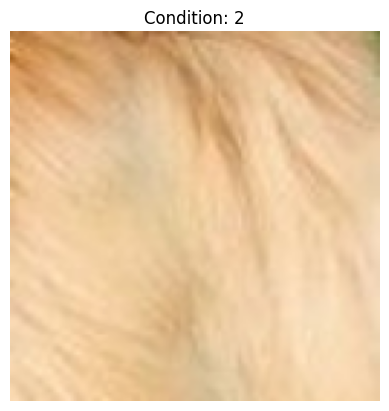

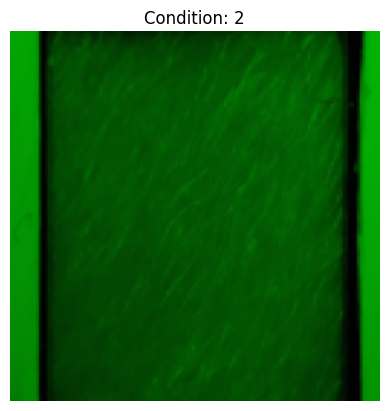

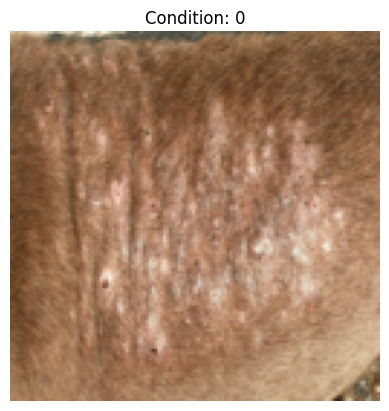

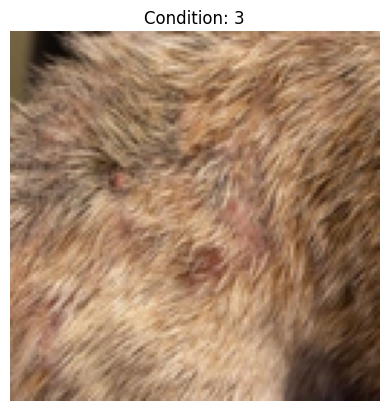

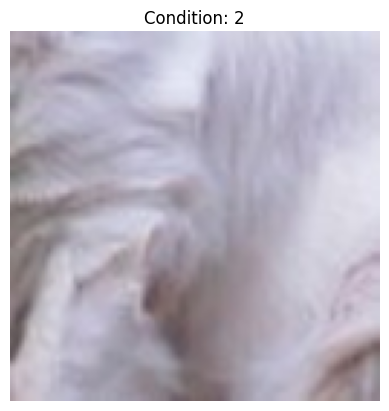

In [29]:
for i in range(5):
  show_image_and_label(imgs_train[i], labels_train[i])

# look through first 5 images

In [5]:
def SimpleConvModel():
    model = tf.keras.models.Sequential(
        [
            Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'),
            Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'),
            tf.keras.layers.Flatten(),  # Flatten the 2D feature maps to a 1D vector
            tf.keras.layers.Dense(64, activation='relu'),  # Add a Dense layer for learning
            tf.keras.layers.Dense(4, activation='softmax')  # Output layer with 4 units for 4 classes
        ]
    )
    return model

model = SimpleConvModel()

def train(model, imgs, labels, loss, name, epochs):
    optimizer = tf.optimizers.Adam(learning_rate=0.0003)
    model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
    model.fit(imgs, labels, epochs=epochs, callbacks=[ShowLearning(imgs, labels, name)])

train(model, imgs_train, labels_train, tf.keras.losses.SparseCategoricalCrossentropy(), 'simple_conv', EPOCHS)

Epoch 1/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 698ms/step - accuracy: 0.3060 - loss: 3106.8750
Epoch 2/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 636ms/step - accuracy: 0.3016 - loss: 530.1223
Epoch 3/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 592ms/step - accuracy: 0.3689 - loss: 161.7289
Epoch 4/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 589ms/step - accuracy: 0.4939 - loss: 59.0301
Epoch 5/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 596ms/step - accuracy: 0.4586 - loss: 42.5658
Epoch 6/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 592ms/step - accuracy: 0.5386 - loss: 29.7675
Epoch 7/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 610ms/step - accuracy: 0.5154 - loss: 25.5094
Epoch 8/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 588ms/step - accuracy: 0.5785 - loss: 25.9007
Epoch 9/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 591ms/step - accuracy: 0.5947 - loss: 23.5007
Epoch 10/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 584ms/step - accuracy: 0.6259 - loss: 19.2872
Epoch 11/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 592ms/step - accuracy: 0.8013 - loss: 6.9657
Epoch 12/40
11/11 ━━━━━━━━━━━━━━━━━━━

In [6]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (1, 128, 128, 16)      │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (1, 128, 128, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (1, 524288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (1, 64)                │    33,554,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (1, 4)                 │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,679,534 (384.06 MB)

 Trainable params: 33,559,844 (128.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 67,119,690 (256.04 MB)

In [7]:
model.save("piecederesistance.h5")